### Model Building
---

In [1]:
# import neccessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,StratifiedKFold,GridSearchCV,cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay,roc_curve,roc_auc_score
import seaborn as sns
from imblearn.over_sampling import SMOTE      #data is not balance
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectFromModel
from imblearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
import warnings
warnings.filterwarnings("ignore",category=FutureWarning)

In [2]:
# load the new data for model building
new_df = pd.read_csv("C:/Users/Taofeek Ogungbemi/Desktop/Data Science/portfolio folder/churn project/data_for_model1.csv")
# convert the target variable to int
new_df["Churn"] = np.where(new_df["Churn"] == "Yes",1,0)
new_df.head(2)

,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_bins
0,No,Yes,No,DSL,No,Yes,No,No,Month-to-month,Yes,Elect-check,29.85,29.85,0,0 - 11
1,No,No,No,DSL,Yes,No,Yes,No,One year,No,Mailed check,56.95,1889.50,0,24 - 35


In [3]:
# split data to features and target
X = new_df.drop("Churn",axis=1)
y = new_df["Churn"]

In [4]:
X.isna().sum()

SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
tenure_bins         0
dtype: int64

In [5]:
# split to test and train set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,stratify=y,random_state=42)   #stratify set to y to make class proportion equal fot both testing and training for each classes
cat_features = X_train.select_dtypes(include=["category","object"]).columns.tolist()
num_features = X_train.select_dtypes(include=["int","float"]).columns.tolist()

In [6]:
# Encoding and scaling the features and target variable
encoder = Pipeline(
    steps=[
        ("one_hot",OneHotEncoder(drop="first",sparse_output=False,handle_unknown="ignore"))
    ])

scaler = Pipeline(steps=[
    ("scaler",StandardScaler())])

# Preprocess the features
preprocessor = ColumnTransformer(transformers=[
    ("cat",encoder,cat_features),
    ("num",scaler,num_features)
])


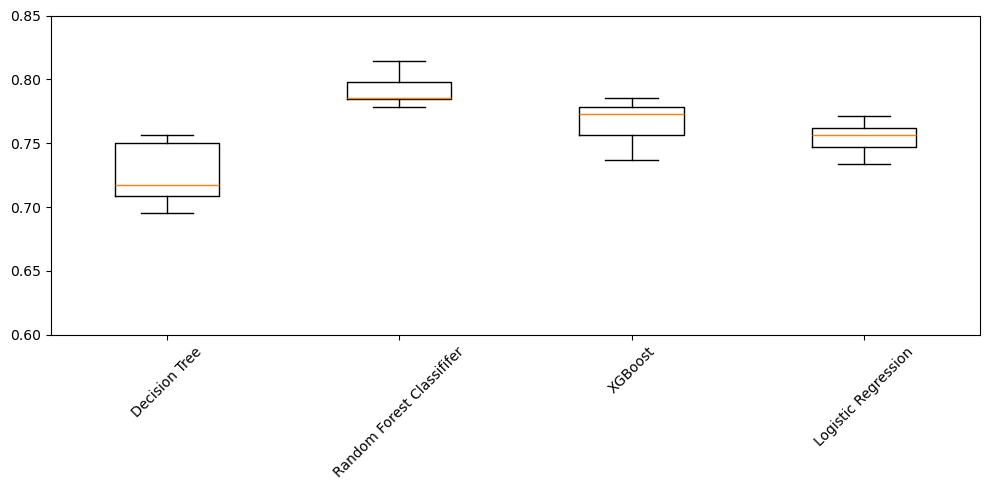

In [7]:
# Let's build four models
def pipeline(model_name):
    return Pipeline(steps = [
        ("preprocessor",preprocessor),
        ("classifier",model_name)
    ])
    
model_list = {"Decision Tree":DecisionTreeClassifier(class_weight="balanced"),
              "Random Forest Classififer":RandomForestClassifier(class_weight="balanced"),
              "XGBoost":XGBClassifier(scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])),
              "Logistic Regression":LogisticRegression(class_weight="balanced")
             }

cv_result = []
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)   # we need to check for several splits so as to check the accuracy score across 
plt.figure(figsize=(10,5))
for i,(name,model) in enumerate(model_list.items()):
    model_pipe = pipeline(model)
    cv_score = cross_val_score(model_pipe,X_train,y_train,cv=skf)
    cv_result.append(cv_score)
plt.boxplot(cv_result,labels=model_list.keys())
plt.ylim(0.6,0.85)  
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- Random Forest classifier perform best among the four models 

In [8]:
# Let's tune the model more to increase its accuracy.
rfc_model = RandomForestClassifier()

# define the param_grid
param_grid = {
    'classifier__n_estimators': [50, 100,200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5]
}
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
rfc_grid = GridSearchCV(estimator=pipeline(rfc_model),param_grid=param_grid,scoring="accuracy",verbose=1)   # grid search to check for best parameters 
rfc_grid.fit(X_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('one_hot',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['SeniorCitizen',
                                                                          'Partner',
                                                                          'Dependents',
                                                                          'InternetService',
                                                                          'OnlineSecurity',
                                                                          'OnlineBackup',
                                                                          'DeviceProtection',
                                                                          'TechSupport',
                                                                          'Contract',
                                                                          'PaperlessBilling',
                                                                          'PaymentMethod',
                                                                          'tenure_bins']),
                                                                        ('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['MonthlyCharges',
                                                                          'TotalCharges'])])),
                                       ('classifier',
                                        RandomForestClassifier())]),
             param_grid={'classifier__max_depth': [None, 10, 20],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=1)

In [9]:
rfc_grid.best_params_

{'classifier__max_depth': 10,
 'classifier__min_samples_split': 5,
 'classifier__n_estimators': 100}

In [10]:
y_pred = rfc_grid.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1549
           1       0.64      0.49      0.56       561

    accuracy                           0.79      2110
   macro avg       0.74      0.70      0.71      2110
weighted avg       0.78      0.79      0.78      2110



***Definition:***
- Precision:
    - Out of all the customers the model predicted would leave, 64% actually left, while 36% stayed.
- Recall
    - Out of all the customers who actually left the company, the model only caught 49% of them. It completely missed the other 51%.
    - Business Impact
        - This is the most dangerous metric for churn. Letting nearly half of the churning customers walk out of the company  without the model noticing.
        - These are "silent churners"—the model thought they were safe, so no retention offer was sent, and business owners lost the revenue.
- Let's prevent this by checking the sweet spot to determine the threshold to tell where model should flag churn or no churn customers

In [37]:
# using the orobability instead of just 1 or 0
y_probs = rfc_grid.predict_proba(X_test)[:, 1]
# default probability threshold is 0.5
threshold = 0.4
# reate new predictions based on this threshold
y_pred_new = (y_probs >= threshold).astype(int)

print(classification_report(y_test, y_pred_new))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85      1549
           1       0.58      0.64      0.61       561

    accuracy                           0.78      2110
   macro avg       0.72      0.74      0.73      2110
weighted avg       0.79      0.78      0.78      2110



- Now model is able to predict more churn customers 

In [38]:
# let's plot the confusion matrix to see how the model perform
confusion_matr = confusion_matrix(y_test,y_pred_new)
confusion_matr

array([[1284,  265],
       [ 200,  361]], dtype=int64)

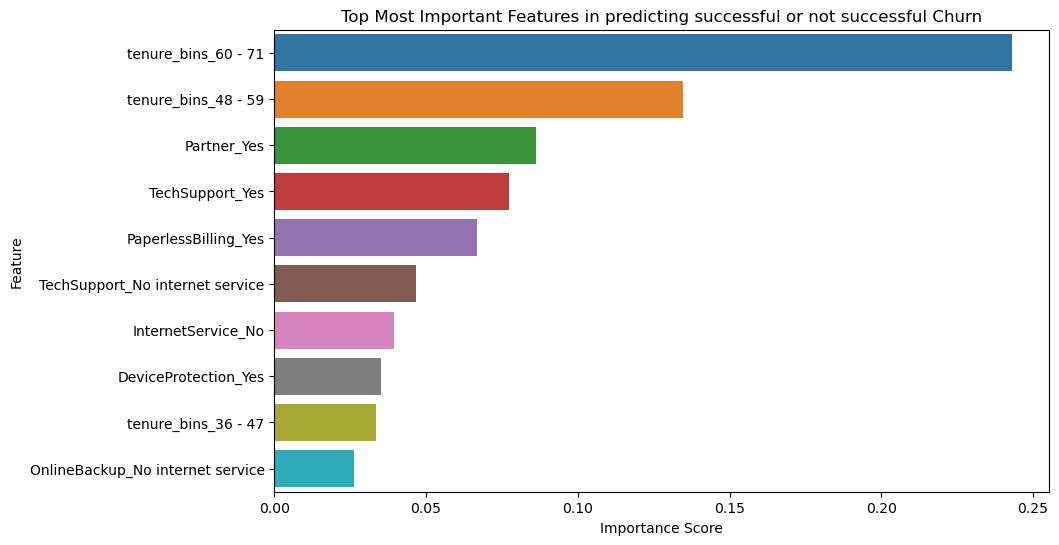

In [13]:
# let's analyze the important features for prediction
feature_importance = rfc_grid.best_estimator_["classifier"].feature_importances_
# we reverse the pipeline 
feature_names = num_features + list(rfc_grid.best_estimator_['preprocessor']
                                        .named_transformers_['cat']
                                        .named_steps['one_hot']
                                        .get_feature_names_out(cat_features))

feature_importances = rfc_grid.best_estimator_['classifier'].feature_importances_

importance_df = pd.DataFrame({'Feature': feature_names,
                              'Importance': feature_importances
                             }).sort_values(by='Importance', ascending=False)   # highest first

top_features = importance_df.head(10)   # just check the bes 10 features.

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot( x= 'Importance',y ='Feature',data = top_features, orient='h')
plt.title(f'Top Most Important Features in predicting successful or not successful Churn')
plt.xlabel('Importance Score')
plt.show()


### Model interpretations
---
1. Tenure is the Dominant Factor
   - The model relies heavily on how long a customer has been with the company to make its prediction.
   - tenure_bins_60-71 (customers with ~5-6 years of history) is by far the most important feature (Score ~0.25).
   - tenure_bins_48-59 is the second most important.

**Interpretation**: The model has learned that long-term loyalty is the strongest indicator of whether a booking (or retention) will be successful. If a customer has been around for years, the model is very confident in its prediction.

2. Personal Stability Matters
  - Partner_Yes is the third most influential feature.

**Interpretation:** Customers who have a partner likely show different stability patterns than single customers, and the model uses this heavily to distinguish between outcomes.

3. Service & Billing Types are Secondary Signals
  - PaperlessBilling_Yes: This suggests that the method of payment is a strong behavioral signal.
  - TechSupport_Yes & DeviceProtection_Yes: Customers who subscribe to value-added support services are likely more "sticky" or engaged, influencing the prediction significantly.

### Postdictive analysis
---
- compare predicted churn vs actual churn
- where did the model perform well?
- where did it fail, and why?y?


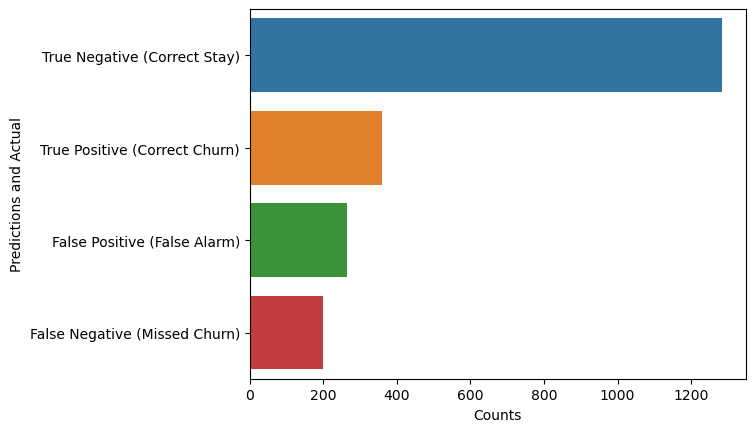

In [36]:
# 2. Create the Master DataFrame
results = X_test.copy()
results['Actual'] = y_test
results['Predicted'] = y_pred_new
results['Prob_Churn'] = y_probs

# 3. Categorize Each Row
def categorize(row):
    if row['Actual'] == 1 and row['Predicted'] == 1:
        return 'True Positive (Correct Churn)'
    elif row['Actual'] == 0 and row['Predicted'] == 0:
        return 'True Negative (Correct Stay)'
    elif row['Actual'] == 0 and row['Predicted'] == 1:
        return 'False Positive (False Alarm)'
    else:
        return 'False Negative (Missed Churn)'

results['Category'] = results.apply(categorize, axis=1)

# print("Distribution of Results:")
result_count = results['Category'].value_counts()
sns.barplot(x = result_count.values,y=result_count.index,orient="h")
plt.xlabel("Counts")
plt.ylabel("Predictions and Actual")
plt.show()

### Interpretations of the chart
---
This chart effectively acts as a visual Confusion Matrix, breaking down where the  model succeeded and where it failed.

1. Compare Predicted Churn vs Actual Churn
   - Success Rate (The "Good" Bars):
   - True Negative (Correct Stay): The blue bar (~1,300 counts) is the largest. This confirms the model is excellent at identifying "safe" customers who are loyal.
   - True Positive (Correct Churn): The orange bar (~360 counts) is substantial. This is the primary value of your model—it successfully flagged ~360 customers who were about to leave, giving the business a chance to save them.

   - Error Rate (The "Bad" Bars):
   - False Positive (False Alarm): The green bar (~260 counts). The model —predicting churn for people who actually stayed.
   - False Negative (Missed Churn): The red bar (~200 counts). The model thought these people were safe, but they left anyway.

2. Where did the model perform well?
-  Identifying Loyal Customers: The massive blue bar proves the model has learned the patterns of stability (likely high tenure and contracts, as seen in the previous importance chart). It rarely confuses a truly happy customer for a churner.

-  Catching Obvious Churners: The solid orange bar suggests the model has correctly identified the "classic" churn profile (e.g., month-to-month users with high bills).

3. Where did it fail, and why?
This is the most critical part..

   - The "Silent Killers" (False Negatives - Red Bar):

What happened: The model missed ~200 churners.

Why: These customers likely looked "safe" on paper (e.g., they might have had long tenure or 2-year contracts) but left due to unseen factors not in the dataset, such as:

- A sudden bad customer service experience.
- A competitor's aggressive flash sale.

